# TUBES 2 AI

## Initiation

In [1]:
import pandas as pd
import pickle
import numpy as np
from collections import Counter
from abc import ABC, abstractmethod
import pickle
from typing import Union
import math
from sklearn.model_selection import KFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
# CONFIG

SKIP_CROSS_VALIDATION = True

CHOSEN_K_VALUE_CUSTOM_KNN = 15
CHOSEN_K_VALUE_SKLEARN_KNN = 15
DEFAULT_K_DIFF = 40
DEFAULT_K_JUMP = 4

## Data Preparation

In [3]:
# TRAINING DATA

data_train = pd.read_csv('data_train.csv')
num_rows, num_columns = data_train.shape

print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_columns}")

data_train

Number of rows: 1400
Number of columns: 21


,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,804,1,0.8,1,12,1,41,0.9,89,1,...,709,818,2027,11,5,11,1,0,0,1
1,1042,0,2.2,0,15,1,11,0.6,139,5,...,68,1018,2826,18,0,2,1,0,0,2
2,1481,1,2.0,1,0,0,35,0.5,105,3,...,249,522,2635,17,16,4,1,0,1,2
3,1104,0,1.7,0,1,1,60,0.4,199,2,...,653,1413,1229,6,0,3,1,1,1,0
4,652,0,0.5,1,1,0,58,0.6,142,3,...,464,781,565,18,12,9,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,536,1,1.4,0,0,1,53,0.7,135,3,...,547,705,1211,15,10,7,1,0,1,0
1396,1097,0,0.8,0,10,1,21,0.1,160,7,...,1277,1352,2219,15,6,12,1,0,1,2
1397,1179,1,0.5,0,7,1,32,0.3,182,2,...,85,1451,340,16,5,16,1,0,0,0
1398,719,1,0.5,1,0,1,23,0.4,113,6,...,431,1727,3990,14,9,12,1,1,1,3


In [4]:
# VALIDATION DATA

data_val = pd.read_csv('data_validation.csv')
num_rows, num_columns = data_val.shape

print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_columns}")

data_val

Number of rows: 600
Number of columns: 21


,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
2,769,1,2.9,1,0,0,9,0.1,182,5,...,248,874,3946,5,2,7,0,0,0,3
3,775,0,1.0,0,3,0,46,0.7,159,2,...,862,1864,568,17,15,11,1,1,1,0
4,595,0,0.9,1,7,1,23,0.1,121,3,...,441,810,3752,10,2,18,1,1,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,1547,1,2.9,0,2,0,57,0.4,114,1,...,347,957,1620,9,2,19,0,1,1,1
596,1882,0,2.0,0,11,1,44,0.8,113,8,...,4,743,3579,19,8,20,1,1,0,3
597,674,1,2.9,1,1,0,21,0.2,198,3,...,576,1809,1180,6,3,4,1,1,1,0
598,1965,1,2.6,1,0,0,39,0.2,187,4,...,915,1965,2032,11,10,16,1,1,1,2


In [5]:
# INI UNTUK SUBMISI KAGGLE

# # Concatenate both datasets
# data_train = pd.concat([data_train, data_val], axis=0)

# # Optional: Reset index if needed
# data_train.reset_index(drop=True, inplace=True)

In [6]:
# REMOVE OUTLIERS

def remove_outliers(data):
    columns_to_exclude = ['blue', 'dual_sim', 'four_g', 'three_g', 'touch_screen', 'wifi', 'price_range']

    # List of columns to exclude from outlier removal
    numeric_columns = data.columns.difference(columns_to_exclude)

    # Hitung IQR untuk kolom numerik
    Q1 = data[numeric_columns].quantile(0.25)
    Q3 = data[numeric_columns].quantile(0.75)
    IQR = Q3 - Q1

    # Menghilangkan outlier pada kolom numerik
    filtered_data = data.copy()
    for column in numeric_columns:
        filtered_data = filtered_data[~((filtered_data[column] < (Q1[column] - 1.5 * IQR[column])) | (filtered_data[column] > (Q3[column] + 1.5 * IQR[column])))]

    return filtered_data
    
data_train_without_outliers = remove_outliers(data_train)
data_val_without_outliers = remove_outliers(data_val)

print("Training data shape after outlier removal:", data_train_without_outliers.shape)
print("Validation data shape after outlier removal:",data_val_without_outliers.shape)

Training data shape after outlier removal: (1389, 21)
Validation data shape after outlier removal: (591, 21)


In [7]:
# COLUMN TYPES

target_column = 'price_range'
binary_categorical_columns = ['blue', 'dual_sim', 'four_g', 'three_g', 'touch_screen', 'wifi']

# List of columns to exclude from outlier removal
numeric_columns = data_train_without_outliers.columns.difference(binary_categorical_columns + [target_column]).to_list()

print("Numeric columns:", numeric_columns)
print("Binary-categorical columns:", binary_categorical_columns)

Numeric columns: ['battery_power', 'clock_speed', 'fc', 'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height', 'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time']
Binary-categorical columns: ['blue', 'dual_sim', 'four_g', 'three_g', 'touch_screen', 'wifi']


Correlation with target:
battery_power    0.186155
blue             0.039261
clock_speed      0.013011
dual_sim        -0.009874
fc              -0.011396
four_g           0.002944
int_memory       0.028786
m_dep            0.001525
mobile_wt       -0.079559
n_cores          0.002999
pc              -0.008949
px_height        0.156057
px_width         0.178814
ram              0.918095
sc_h             0.015504
sc_w             0.019167
talk_time        0.011592
three_g          0.027510
touch_screen    -0.034396
wifi             0.032942
price_range      1.000000
Name: price_range, dtype: float64


<AxesSubplot: >

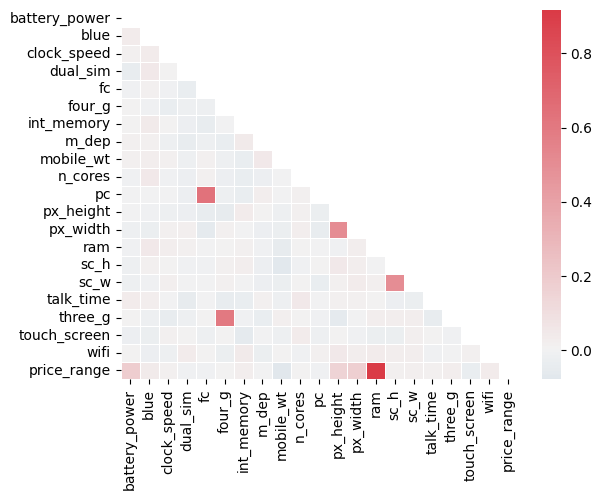

In [8]:
# Calculate the correlation with the target column ('target')
corr_with_target = data_train_without_outliers.corr()[target_column]

print("Correlation with target:")
print(corr_with_target)

# Calculate the correlation matrix
corr = data_train_without_outliers.corr(method='pearson')
corr.head()


# Create a heatmap to visualize the correlation
# This is to remove the top right triange - because that's just duplicate information
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Colors
cmap = sns.diverging_palette(240, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, linewidths=.5, cmap=cmap, center=0)

In [9]:
# REMOVE ATTRIBUTES WITH LOW CORRELATION WITH TARGET

minimum_corr = 0.025
drop_columns = corr_with_target[abs(corr_with_target) < minimum_corr].index.values;

print("drop_columns:", drop_columns)

data_train_with_corr = data_train_without_outliers.drop(drop_columns, axis=1)
data_val_with_corr = data_val.drop(drop_columns, axis=1)

def remove_drop_columns(column_list):
    for column in drop_columns:
        if column in column_list:
            column_list.remove(column)

    return column_list

remove_drop_columns(binary_categorical_columns)
remove_drop_columns(numeric_columns)

print("binary_categorical_columns:", binary_categorical_columns)
print("numeric_columns:", numeric_columns)

drop_columns: ['clock_speed' 'dual_sim' 'fc' 'four_g' 'm_dep' 'n_cores' 'pc' 'sc_h'
 'sc_w' 'talk_time']
binary_categorical_columns: ['blue', 'three_g', 'touch_screen', 'wifi']
numeric_columns: ['battery_power', 'int_memory', 'mobile_wt', 'px_height', 'px_width', 'ram']


## Abstract Base Model

In [10]:
class Model(ABC):
    def __init__(self):
        pass

    def __accuracy_score(self, y_true: np.ndarray, y_pred: np.ndarray) -> float:
        """
        Calculate accuracy score between true labels (y_true) and predicted labels (y_pred).
        """
        correct_predictions = np.sum(y_true == y_pred)
        total_samples = len(y_true)
        accuracy = correct_predictions / total_samples
        return accuracy
    
    @classmethod
    def load(cls, filepath: str) -> 'Model':
        """
        Load a trained model from a file using pickle deserialization.
        """
        with open(filepath, 'rb') as file:
            loaded_model = pickle.load(file)
        return loaded_model

    @abstractmethod
    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        """
        Train the model on the input data X and corresponding labels y.
        This method must be implemented by subclasses.
        """
        pass

    @abstractmethod
    def _predict(self, x: np.ndarray) -> Union[int, float]:
        pass

    def predict(self, X: np.ndarray) -> np.ndarray:
        predictions = [self._predict(x) for x in X]
        return np.array(predictions)
    
    def evaluate(self, X: np.ndarray, y: np.ndarray) -> float:
        """
        Evaluate the model on the input data X and corresponding labels y.
        """
        y_pred = self.predict(X)
        return self.__accuracy_score(y, y_pred)

    def save(self, filepath: str) -> None:
        """
        Save the trained model to a file using pickle serialization.
        """
        with open(filepath, 'wb') as file:
            pickle.dump(self, file)

    def score(self, X: np.ndarray, y: np.ndarray) -> float:
        """
        Score the model on the input data X and corresponding labels y.
        """
        return self.evaluate(X, y)


## Algoritma KNN (Custom)

In [11]:
# MODEL

class KNNModel(Model):
    def __init__(self, n_neighbors: int = 3):
        super().__init__()
        self.n_neighbors = n_neighbors
        self.X_train = None
        self.y_train = None

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self.X_train = X
        self.y_train = y

    def _predict(self, x: np.ndarray) -> Union[int, float]:
        # Compute the distance
        distances = [np.linalg.norm(x - x_train) for x_train in self.X_train]

        # Get the closest k
        k_indices = np.argsort(distances)[:self.n_neighbors]
        k_nearest_labels = [self.y_train[i] for i in k_indices]

        # Majority vote
        most_common = Counter(k_nearest_labels).most_common(1)
        return most_common[0][0]

In [12]:
# DATA PREPROCESSING PIPELINE

from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# Preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),
])

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_columns),
        ('binary_cat', 'passthrough', binary_categorical_columns),
    ]
)

In [13]:
# Separate Features and Labels for training

X_train = data_train_with_corr.drop(target_column, axis=1)
y_train = data_train_with_corr[target_column]

# Separate Features and Labels for validation
X_val = data_val_with_corr.drop(target_column, axis=1)
y_val = data_val_with_corr[target_column]


In [14]:
# DATA TRANSFORMATION

# Transform the training data
X_train_transformed = preprocessor.fit_transform(X_train)

# Transform the validation data
X_val_transformed = preprocessor.transform(X_val)


In [15]:
correlation_matrix = X_train.corrwith(y_train).abs()
column_order = preprocessor.transformers_[0][2] + preprocessor.transformers_[1][2]
correlation_matrix_reordered = correlation_matrix[column_order].reindex(index=column_order)

print(correlation_matrix_reordered.sort_values(ascending=False))

custom_weights = correlation_matrix_reordered.values

ram              0.918095
battery_power    0.186155
px_width         0.178814
px_height        0.156057
mobile_wt        0.079559
blue             0.039261
touch_screen     0.034396
wifi             0.032942
int_memory       0.028786
three_g          0.027510
dtype: float64


In [16]:
# FEATURE SCALING

X_train_scaled = X_train_transformed * custom_weights
X_val_scaled = X_val_transformed * custom_weights

In [17]:
X_train_final = X_train_scaled
X_val_final = X_val_scaled

In [18]:
# RULE OF THUMB FOR K VALUE IN KNN

heuristic_k = math.floor(math.sqrt(data_train_with_corr.shape[0]))
if (heuristic_k % 2 == 0):
    heuristic_k += 1

print(heuristic_k)

37


In [19]:
# CROSS VALIDATION FOR OPTIMAL K VALUE

def custom_cross_val_score(model, X: np.ndarray, y: np.ndarray, cv: int = 5) -> float:
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    scores = []

    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        model.fit(X_train, y_train)
        accuracy = model.score(X_val, y_val)
        scores.append(accuracy)

    average_score = sum(scores) / len(scores)
    return average_score

# Example usage:
knn_model = KNNModel(n_neighbors=heuristic_k)

# Assuming X_train_transformed and y_train are your training data
# Assuming X_val_final and y_val are your validation data

# Concatenate X_train_final and X_val_final along the rows
X_combined = np.concatenate([X_train_final, X_val_final], axis=0)

# Concatenate y_train and y_val along the rows
y_combined = pd.concat([y_train, y_val], axis=0).values

k_diff = 0 if SKIP_CROSS_VALIDATION else DEFAULT_K_DIFF

default_k = CHOSEN_K_VALUE_CUSTOM_KNN if SKIP_CROSS_VALIDATION else heuristic_k

k_min = max(3, default_k - k_diff);
k_max = min(len(X_train_final), default_k + k_diff)

best_k = default_k
best_score = 0

for i in range(k_min, k_max + 1, DEFAULT_K_JUMP):
    knn_model = KNNModel(n_neighbors=i)
    score = custom_cross_val_score(knn_model, X_combined, y_combined, 5)
    print(f"K: {i}, score: {score:.2f}")

    if (score > best_score):
        best_score = score
        best_k = i

print(f"Best K: {best_k}, score: {best_score:.2f}")

K: 15, score: 0.94
Best K: 15, score: 0.94


In [20]:
# X_test_final and y_test (test data)

# Initialize variables to store the best accuracy and corresponding k
best_test_accuracy = 0
best_test_k = best_k

print(best_k, len(X_train_final))

# Iterate through odd values of k starting from best_k to test on the test set
for k in range(1, best_k + 5):
    knn_model = KNNModel(n_neighbors=k)
    knn_model.fit(X_train_final, y_train.values)
    
    # Evaluate the model on the test set
    accuracy_test = knn_model.evaluate(X_val_final, y_val.values)
    
    # Update the best test accuracy and corresponding k if a better accuracy is found
    if accuracy_test > best_test_accuracy:
        best_test_accuracy = accuracy_test
        best_test_k = k

    print(f"K: {k}, Test accuracy: {accuracy_test:.4f}")

print(f"Best K for test data: {best_test_k}, Test accuracy: {best_test_accuracy:.4f}")

15 1389
K: 1, Test accuracy: 0.9133
K: 2, Test accuracy: 0.9133
K: 3, Test accuracy: 0.9117
K: 4, Test accuracy: 0.9167
K: 5, Test accuracy: 0.9200
K: 6, Test accuracy: 0.9233
K: 7, Test accuracy: 0.9233
K: 8, Test accuracy: 0.9283
K: 9, Test accuracy: 0.9267
K: 10, Test accuracy: 0.9300
K: 11, Test accuracy: 0.9200
K: 12, Test accuracy: 0.9283
K: 13, Test accuracy: 0.9217
K: 14, Test accuracy: 0.9250
K: 15, Test accuracy: 0.9233
K: 16, Test accuracy: 0.9283
K: 17, Test accuracy: 0.9167
K: 18, Test accuracy: 0.9250
K: 19, Test accuracy: 0.9200
Best K for test data: 10, Test accuracy: 0.9300


In [21]:
# # Merge features X_train_final and X_val_final
# X_merged = np.concatenate((X_train_final, X_val_final), axis=0)

# # Merge target variables y_train and y_val
# y_merged = np.concatenate((y_train, y_val), axis=0)

# knn_model.fit(X_merged, y_merged)

In [22]:
# Instantiate and Train the Model

knn_model = KNNModel(n_neighbors=best_test_k)

knn_model.fit(X_train_final, y_train.values)

# Evaluate the Model on the Validation Set
accuracy_val = knn_model.evaluate(X_val_final, y_val.values)

print(f"Validation accuracy: {accuracy_val}")

Validation accuracy: 0.93


In [23]:
# SAVE AND LOAD MODEL

knn_model.save("custom_knn_model.pkl")
saved_knn_model = KNNModel.load("custom_knn_model.pkl")
# saved_knn_model.evaluate(X_val_final, y_val.values)

## Algoritma KNN (Scikit-learn)

In [24]:
# SK-LEARN CROSS VALIDATION

def find_best_k(X, y, num_folds=5):
    best_k = None
    best_accuracy = 0.0

    sk_learn_default_k = CHOSEN_K_VALUE_SKLEARN_KNN if SKIP_CROSS_VALIDATION else heuristic_k   
    sk_learn_k_diff = 0 if SKIP_CROSS_VALIDATION else DEFAULT_K_DIFF
    
    sk_learn_min_k = max(3, sk_learn_default_k - sk_learn_k_diff)
    sk_learn_max_k = min(len(X_train_final), sk_learn_default_k + sk_learn_k_diff)

    for k in range(sk_learn_min_k, sk_learn_max_k + 1, DEFAULT_K_JUMP):
        knn_model = KNeighborsClassifier(n_neighbors=k)
        kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
        cross_val_scores = cross_val_score(knn_model, X, y, cv=kf, scoring='accuracy')
        average_accuracy = cross_val_scores.mean()

        if average_accuracy > best_accuracy:
            best_accuracy = average_accuracy
            best_k = k

    return best_k, best_accuracy

# Assuming you have already preprocessed your data and have X_train_transformed, y_train
sk_learn_best_k, sk_learn_best_accuracy = find_best_k(X_combined, y_combined)

print(f"Best k: {best_k}, Best Accuracy: {sk_learn_best_accuracy:.2%}")

Best k: 15, Best Accuracy: 93.77%


In [25]:
# MODEL VALIDATION

# Instantiate the KNeighborsClassifier
sk_learn_knn_model = KNeighborsClassifier(n_neighbors=sk_learn_best_k)

# Train the model
sk_learn_knn_model.fit(X_train_final, y_train)

# Make predictions on the validation set
y_val_pred = knn_model.predict(X_val_final)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {accuracy:.2%}")

Validation Accuracy: 93.00%


## Kaggle Submission

### Algoritma KNN

In [26]:
# TEST DATA PREPROCESSING

data_test = pd.read_csv('test.csv')

data_test_with_corr = data_test.drop(drop_columns, axis=1)

X_test = data_test_with_corr.drop('id', axis=1)
X_test_transformed = preprocessor.fit_transform(X_test)
X_test_scaled = X_test_transformed * custom_weights

X_test_final = X_test_scaled

In [27]:
# PREDICTION

saved_knn_model = KNNModel.load("custom_knn_model.pkl")
predictions = saved_knn_model.predict(X_test_final)

# Create a DataFrame with default index and 'price_range' column
result_df = pd.DataFrame({'id': range(len(predictions)), 'price_range': predictions})
result_df.to_csv('predictions_knn.csv', sep=',', index=False)

# Display the resulting DataFrame
result_df

,id,price_range
0,0,0
1,1,3
2,2,3
3,3,2
4,4,0
...,...,...
1995,1995,2
1996,1996,0
1997,1997,3
1998,1998,0


## TESTING (GA MASUK PENGUMPULAN)

In [28]:
# KNN tanpa preprocessing 

knn_model_test = KNNModel(n_neighbors=best_k)
knn_model_test.fit(X_train.values, y_train.values)

# Evaluate the Model on the Validation Set
accuracy_val = knn_model_test.evaluate(X_val.values, y_val.values)

print(f"Validation accuracy: {accuracy_val}")

predictions = knn_model_test.predict(X_test.values)

# Create a DataFrame with default index and 'price_range' column
result_df = pd.DataFrame({'id': range(len(predictions)), 'price_range': predictions})
result_df.to_csv('predictions_knn_test.csv', sep=',', index=False)

# Display the resulting DataFrame
result_df


Validation accuracy: 0.9233333333333333


,id,price_range
0,0,0
1,1,3
2,2,3
3,3,2
4,4,0
...,...,...
1995,1995,2
1996,1996,0
1997,1997,3
1998,1998,0


## Algoritma Naive-Bayes (Custom)

### Best Discretization Test

In [29]:
# Show data train head
data_train_without_outliers.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,804,1,0.8,1,12,1,41,0.9,89,1,...,709,818,2027,11,5,11,1,0,0,1
1,1042,0,2.2,0,15,1,11,0.6,139,5,...,68,1018,2826,18,0,2,1,0,0,2
2,1481,1,2.0,1,0,0,35,0.5,105,3,...,249,522,2635,17,16,4,1,0,1,2
3,1104,0,1.7,0,1,1,60,0.4,199,2,...,653,1413,1229,6,0,3,1,1,1,0
4,652,0,0.5,1,1,0,58,0.6,142,3,...,464,781,565,18,12,9,0,0,1,0


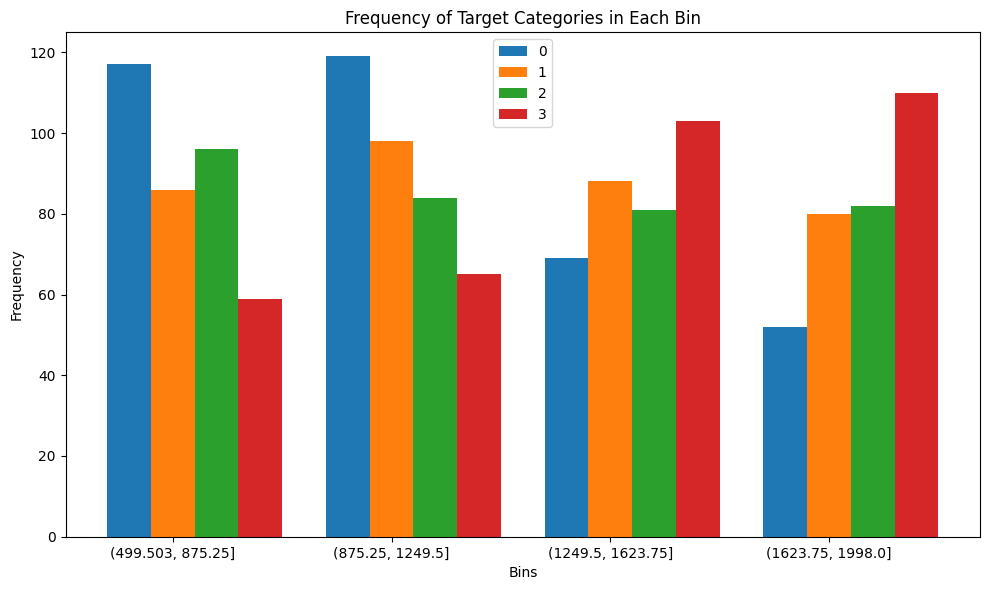

In [30]:
# data_train_without_outliers

def visualize_bin(df, col, k):
    df['Bins'] = pd.cut(df[col], k)
    freq_table = df.groupby(['Bins', target_column]).size().unstack(fill_value=0)

    plt.figure(figsize=(10, 6))
    bar_width = 0.2
    index = np.arange(len(freq_table))

    for i, col in enumerate(freq_table.columns):
        plt.bar(index + i * bar_width, freq_table[col], bar_width, label=col)

    plt.xlabel('Bins')
    plt.ylabel('Frequency')
    plt.title('Frequency of Target Categories in Each Bin')
    plt.xticks(index + bar_width, freq_table.index)
    plt.legend()
    plt.tight_layout()
    plt.show()


visualize_bin(data_train_without_outliers, 'battery_power', 4)

### Naive-Bayes Model Attempt 1

In [31]:
# Convert numerical data to categorical data
n_bin = 4

nb_data_train = data_train_with_corr.copy()
bin_edges = {}
for column in numeric_columns:
    bins, edges = pd.cut(nb_data_train[column], bins=n_bin, retbins=True, labels=[x for x in range(n_bin)])
    nb_data_train[column] = bins

    print(edges)
    bin_edges[column] = edges;

print(bin_edges)
nb_data_train

[ 499.503  875.25  1249.5   1623.75  1998.   ]
[ 1.938 17.5   33.    48.5   64.   ]
[ 79.88 110.   140.   170.   200.  ]
[  -1.96  490.    980.   1470.   1960.  ]
[ 498.502  874.5   1249.    1623.5   1998.   ]
[ 252.258 1191.5   2127.    3062.5   3998.   ]
{'battery_power': array([ 499.503,  875.25 , 1249.5  , 1623.75 , 1998.   ]), 'int_memory': array([ 1.938, 17.5  , 33.   , 48.5  , 64.   ]), 'mobile_wt': array([ 79.88, 110.  , 140.  , 170.  , 200.  ]), 'px_height': array([  -1.96,  490.  ,  980.  , 1470.  , 1960.  ]), 'px_width': array([ 498.502,  874.5  , 1249.   , 1623.5  , 1998.   ]), 'ram': array([ 252.258, 1191.5  , 2127.   , 3062.5  , 3998.   ])}


,battery_power,blue,int_memory,mobile_wt,px_height,px_width,ram,three_g,touch_screen,wifi,price_range
0,0,1,2,0,1,0,1,1,0,0,1
1,1,0,0,1,0,1,2,1,0,0,2
2,2,1,2,0,0,0,2,1,0,1,2
3,1,0,3,3,1,2,1,1,1,1,0
4,0,0,3,2,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
1395,0,1,3,1,1,0,1,1,0,1,0
1396,1,0,1,2,2,2,2,1,0,1,2
1397,1,1,1,3,0,2,0,1,0,0,0
1398,0,1,1,1,0,3,3,1,1,1,3


In [32]:
class NBModel(Model):
    def __init__(self, numeric_columns: list, n_bin: dict):
        super().__init__()
        self.numeric_columns = numeric_columns
        self.n_bin = n_bin
        self.X_prob_values: dict = {}
        self.y_prob_values: dict = {}
        self.edges: dict = {}


    def fit(self, X: np.ndarray, y: np.ndarray):
        X_cpy = X.copy()

        # split data into bins
        for column in self.numeric_columns:
            bins, edges = pd.cut(X_cpy[column], bins=self.n_bin[column], retbins=True, labels=[x for x in range(self.n_bin[column])])
            X_cpy[column] = bins
            self.edges[column] = edges;

        # calculate probability
        for i, target in enumerate(y.value_counts()):
            self.y_prob_values[i] = target / len(y)
        
        for column in X_cpy.columns:
            self.X_prob_values[column] = {}

            temp_df = pd.concat([X_cpy[column], y], axis=1)

            # Add sentinel value to make sure no zero
            for x_val in temp_df[column].unique():
                for y_val in temp_df[target_column].unique():
                    temp_df = temp_df.append({column: x_val, target_column: y_val}, ignore_index=True)
            
            temp_df = temp_df.groupby(column).apply(lambda x: x.value_counts() / len(x))
            for key, val in temp_df.to_dict().items():
                if (key[0] not in self.X_prob_values[column]):
                    self.X_prob_values[column][key[0]] = {}
                self.X_prob_values[column][key[0]][key[2]] = val


    def predict(self, X: np.ndarray) -> np.ndarray:
        predictions = [self._predict(x) for idx, x in X.iterrows()]
        return np.array(predictions)


    def _predict(self, x: np.ndarray):
        mx: float = 0
        res: int = -1

        # Preprocess the input
        x_cpy = x.copy()

        for column in self.numeric_columns:
            for i in range(len(self.edges[column]) - 1):
                # if column == 'mobile_wt':
                #     print(self.edges[column][i], self.edges[column][i + 1], i)
                if (self.edges[column][i + 1] >= x_cpy[column]):
                    x_cpy[column] = i
                    break

        # print(x_cpy)

        for target in self.y_prob_values.keys():
            temp = 1

            for i, column in enumerate(self.X_prob_values.keys()):
                # print(column, x_cpy[column], target)
                # print(self.X_prob_values[column][x_cpy[column]])
                if (column not in ['px_height', 'px_width', 'battery_power', 'ram']):
                # if (column not in ['battery_power', 'ram']):
                    continue
                temp *= self.X_prob_values[column][x_cpy[column]][target]

            if temp > mx:
                mx = temp
                res = target
        
        return res


# num_col = ['battery_power', 'int_memory', 'mobile_wt', 'px_height', 'px_width', 'ram']
# num_col = ['px_height', 'px_width', 'battery_power', 'ram']

# maxval = 0
# maxbin = [0, 0, 0, 0]
# for col0 in range(4, 11):
#     for col1 in range(4, 11):
#         for col2 in range(4, 11):
#             for col3 in range(4, 11):
#                 for col4 in range(4, 11):
#                     for col5 in range(4, 11):
#                         model = NBModel(num_col, {num_col[0]: col0, num_col[1]: col1, num_col[2]: col2, num_col[3]: col3, num_col[4]: col4, num_col[5]: col5})
#                         model.fit(X_train, y_train)
#                         temp = model.evaluate(X_val, y_val)

#                         if (temp > maxval):
#                             print(f"[{col0}, {col1}, {col2}, {col3}, {col4}, {col5}]: {temp}")
#                             maxval = temp
#                             maxbin = [col0, col1, col2, col3, col4, col5]

# for col0 in range(4, 9):
#     for col1 in range(4, 9):
#         for col2 in range(4, 9):
#             for col3 in range(4, 9):
#                 model = NBModel(num_col, {num_col[0]: col0, num_col[1]: col1, num_col[2]: col2, num_col[3]: col3})
#                 model.fit(X_train, y_train)
#                 temp = model.evaluate(X_val, y_val)

#                 print(f"[{col0}, {col1}, {col2}, {col3}]: {temp}")
#                 if (temp > maxval):
#                     maxval = temp
#                     maxbin = [col0, col1, col2, col3]
    

# print(f"{maxbin}: {maxval}")
# for i in range(2, 11):
#     model = NBModel(i)
#     model.fit(X_train, y_train)
#     print(model.evaluate(X_val, y_val))

In [33]:
# PREDICTION
nb_model = 0
nb_model = NBModel(['px_height', 'px_width', 'battery_power', 'ram'], {'px_height': 6, 'px_width': 5, 'battery_power': 4, 'ram': 6})
nb_model.fit(X_train, y_train)
nb_predictions = nb_model.predict(X_val)

accuracy = accuracy_score(y_val, nb_predictions)
print("Accuracy:", accuracy)

Accuracy: 0.81


In [34]:
# SAVE MODEL
nb_model.fit(X_train, y_train)
nb_model.save('custom_nb_model.pkl')

In [42]:
# LOAD MODEL
saved_nb_model = NBModel.load('custom_nb_model.pkl')

saved_nb_predictions = saved_nb_model.predict(X_val)
accuracy = accuracy_score(y_val, saved_nb_predictions)

print("Accuracy:", accuracy)

Accuracy: 0.81


In [36]:
# PREDICTION
nb_kaggle_model = 0
nb_kaggle_model = NBModel(['px_height', 'px_width', 'battery_power', 'ram'], {'px_height': 6, 'px_width': 5, 'battery_power': 4, 'ram': 6})
nb_kaggle_model.fit(X_train, y_train)
nb_predictions = nb_kaggle_model.predict(X_test)

# Create a DataFrame with default index and 'price_range' column
nb_result_df = pd.DataFrame({'id': range(len(predictions)), 'price_range': predictions})
nb_result_df.to_csv('predictions_nb.csv', sep=',', index=False)

# Display the resulting DataFrame
nb_result_df

,id,price_range
0,0,0
1,1,3
2,2,3
3,3,2
4,4,0
...,...,...
1995,1995,2
1996,1996,0
1997,1997,3
1998,1998,0


## Algoritma Naive-Bayes (Scikit-learn)

### Gaussian Naive Bayes

In [37]:
nb_classifier = GaussianNB()
X_train_drop_col = X_train.copy()
nb_classifier.fit(X_train, y_train)

y_pred = nb_classifier.predict(X_val)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {accuracy:.2%}")

Validation Accuracy: 78.50%


### Multinomial Naive Bayes

In [38]:
nb_multinomial_classifier = MultinomialNB()
nb_multinomial_classifier.fit(X_train, y_train)

y_pred = nb_multinomial_classifier.predict(X_val)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {accuracy:.2%}")

Validation Accuracy: 52.00%


### Bernoulli Naive Bayes

In [39]:
nb_multinomial_classifier = BernoulliNB()
nb_multinomial_classifier.fit(X_train, y_train)

y_pred = nb_multinomial_classifier.predict(X_val)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {accuracy:.2%}")

Validation Accuracy: 21.83%


### Gaussian Naive Bayes - Custom

In [40]:
class GaussianNB(Model):
    def __init__(self):
        super().__init__()
        self.classes = None
        self.class_priors = None
        self.class_means = None
        self.class_variances = None

    def fit(self, X: pd.DataFrame, y: np.ndarray) -> None:
        self.classes = np.unique(y)
        self.class_priors = np.zeros(len(self.classes))
        self.class_means = np.zeros((len(self.classes), X.shape[1]))
        self.class_variances = np.zeros((len(self.classes), X.shape[1]))

        for idx, c in enumerate(self.classes):
            X_c = X[y == c]
            self.class_priors[idx] = len(X_c) / len(X)
            self.class_means[idx] = np.mean(X_c, axis=0)
            self.class_variances[idx] = np.var(X_c, axis=0)

    def predict(self, X: np.ndarray) -> np.ndarray:
        predictions = [self._predict(x) for idx, x in X.iterrows()]
        return np.array(predictions)

    def _predict(self, x: np.ndarray) -> int:
        posteriors = []

        for idx, c in enumerate(self.classes):
            prior = np.log(self.class_priors[idx])
            class_mean = self.class_means[idx]
            class_variance = self.class_variances[idx]

            posterior = prior + np.sum(-0.5 * np.log(2 * np.pi * class_variance)
                                       - 0.5 * ((x - class_mean) ** 2) / class_variance)
            posteriors.append(posterior)

        return self.classes[np.argmax(posteriors)]


In [41]:
gnb = GaussianNB()

# Train the model
gnb.fit(X_train, y_train)

gnb_predictions = gnb.predict(X_val)

# Evaluate the model
accuracy = accuracy_score(y_val, gnb_predictions)
print("Accuracy:", accuracy)

Accuracy: 0.785


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a963f65a-53a6-4082-84fc-4851df98aad3' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>